# Notebook experiment on image input size and neural net layer activation
The goal of this notebook is to test if we can freely upsample the input image of neural net and get similar activation on convolutional layer

In [1]:
from torchvision import models
import torch
import numpy as np
import skimage
import sys
import matplotlib.pyplot as plt
from skimage import io
import urllib
import os
import pretrainedmodels
torch.manual_seed(0)

In [2]:
alexnet_model = models.alexnet(pretrained=True).eval()
for param in alexnet_model.parameters():
    param.requires_grad = False

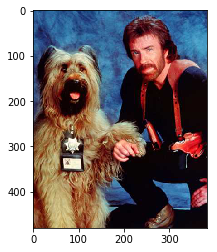

In [3]:
img = io.imread("./chuck-norris-top-dog.jpg")
imgplot = plt.imshow(img)

In [ ]:
classes_url = "https://raw.githubusercontent.com/Cadene/pretrained-models.pytorch/master/data/imagenet_classes.txt"
synsets_url = "https://raw.githubusercontent.com/Cadene/pretrained-models.pytorch/master/data/imagenet_synsets.txt"

for url in [classes_url, synsets_url]:
    urllib.request.urlretrieve(url, "./{}".format(os.path.basename(url)))


In [7]:
synset_to_class = dict()
with open("./imagenet_synsets.txt") as synsets_file:
    for line in synsets_file:
        tokens = line.strip().split(" ")
        synset_to_class[tokens[0]] = " ".join(tokens[1:])
        
index_to_synsets = dict()
with open("./imagenet_classes.txt") as class_file:
    for i, line in enumerate(class_file):
        synset = line.strip()
        index_to_synsets[i] = synset

In [8]:
sys.path.append("..")
from image_utils.data_loading import load_image
my_img = load_image("./chuck-norris-top-dog.jpg", size=(224, 224))

Let's have a look at the class detected for this image

In [9]:
def get_class_from_activations(my_classes):
    predicted_class = int(np.argmax(my_classes.numpy()))
    class_, score =  synset_to_class[index_to_synsets[predicted_class]], my_classes[0, predicted_class]
    print("Found class {} with score {}".format(class_, score))
    return class_, score

logits = alexnet_model.forward(my_img)
_ = get_class_from_activations(logits)


Found class briard with score 9.576154708862305


Here, we just add a sanity check on the decomposition of the network in its two parts : features and classifier

In [10]:
model_parts = list(alexnet_model.children())
feature = model_parts[0]
classif = model_parts[1]

img_feats = feature(my_img)
new_logits = classif(img_feats.view(1, -1))

assert(torch.all(new_logits == logits))

In [11]:
def upscale_drift(factor, feature, classif, img_feats, pooling=torch.nn.AvgPool2d):
    # Load the image a bit bigger
    my_bigger_img = load_image("./chuck-norris-top-dog.jpg", size=(factor*224, factor*224))
    
    # Run through the feature part like this
    bigger_img_feats = feature(my_bigger_img)
    pool = pooling(factor, factor)
    
    # escale before the fully connected
    rescaled_img_feats = pool(bigger_img_feats)
    # Get the class 
    new_logits = classif(rescaled_img_feats.view(1, -1))
    get_class_from_activations(new_logits)

### Experiment 1  : Mean pool the feature to feat the classifier

In [19]:
for factor in range(1, 7):
    upscale_drift(factor, feature, classif, img_feats)

Found class briard with score 9.576154708862305
Found class Maltese dog, Maltese terrier, Maltese with score 7.593825817108154
Found class axolotl, mud puppy, Ambystoma mexicanum with score 5.560885906219482
Found class chambered nautilus, pearly nautilus, nautilus with score 5.159115314483643
Found class chambered nautilus, pearly nautilus, nautilus with score 5.35198974609375
Found class chambered nautilus, pearly nautilus, nautilus with score 5.1386847496032715


## Results
We can observe a fast deterioration of the predicted class when we change the image input size
With a factor of two, we still have the same kind of prediction.
Beyond, predictions start to be erroneous

### Experiment 2  : Test with max-pooling

In [18]:
for factor in range(1, 11):
    upscale_drift(factor, feature, classif, img_feats, pooling=torch.nn.MaxPool2d)

Found class briard with score 9.576154708862305
Found class Maltese dog, Maltese terrier, Maltese with score 9.69753646850586
Found class wig with score 8.1404390335083
Found class axolotl, mud puppy, Ambystoma mexicanum with score 9.068302154541016
Found class axolotl, mud puppy, Ambystoma mexicanum with score 8.694751739501953
Found class axolotl, mud puppy, Ambystoma mexicanum with score 8.299294471740723
Found class axolotl, mud puppy, Ambystoma mexicanum with score 7.948156833648682
Found class electric ray, crampfish, numbfish, torpedo with score 7.683897972106934
Found class electric ray, crampfish, numbfish, torpedo with score 7.507132053375244
Found class electric ray, crampfish, numbfish, torpedo with score 7.1715826988220215


## Results
Max pooling seems more difficult to justify as a choice to keep the feature map unchanged after the feature phase.
Interestingly the score obtained on the final layer is higher even if we go through approximately the same classes.

In [36]:
from tensorboardX import SummaryWriter
pooling=torch.nn.AvgPool2d

with SummaryWriter(comment='AlexNetConv') as w:
    for scale in range(1, 5):
        my_bigger_img = load_image("./chuck-norris-top-dog.jpg", size=(scale*224, scale*224))
        bigger_img_feats = feature(my_bigger_img)
        pool = pooling(scale, scale)(bigger_img_feats)
        print(torch.mean(pool.view(-1)))
        w.add_histogram("feature_dist", pool.view(-1), scale)



tensor(0.6888)
tensor(0.4442)
tensor(0.3082)
tensor(0.2584)
